In [1]:
import h5py
import torch
import numpy as np
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import json

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
job = {
    'config': {},
    'results': {}
}

In [2]:
# This becomes the subdir under the dir with modelname; use it to indicate other experiment details
# Besides model name, which indicates architecture / forward pass
# So use it to indicate regularization, loss function, optimizer, etc.
experiment_name = "cos_adam_80epochs"
job['config']['experiment_name'] = experiment_name

#### Set up datasets, get baseline stats

In [3]:
class TripletDataset(Dataset):
    def __init__(self, path, hard_ratio=0.5):
        with h5py.File(path, "r") as f:
            self.anchors = torch.from_numpy(f["queries"][:]).float()
            self.positives = torch.from_numpy(f["positives"][:]).float()
            self.hard_negatives = torch.from_numpy(f["hard_negatives"][:]).float()
            self.soft_negatives = torch.from_numpy(f["soft_negatives"][:]).float()
        self.hard_ratio = hard_ratio

    def __sample_row(self, rows):
        idx = np.random.randint(len(rows))
        return rows[idx]

    def __len__(self):
        return len(self.anchors)
    
    def __getitem__(self, idx):
        anchor = self.anchors[idx]
        positives = self.positives[idx]
        positive = self.__sample_row(positives)

        negatives = self.hard_negatives[idx] if np.random.rand() < self.hard_ratio else self.soft_negatives[idx]
        negative = self.__sample_row(negatives)
        return anchor, positive, negative

train_path = "../data/dataset/nn/train_triplet_ds_add_prev_2.h5"
val_path = "../data/dataset/nn/val_triplet_ds_add_prev_2.h5"
val_queries = "../data/dataset/nn/val_ds_add_prev_2.jsonl"
# no need for test path here
train_ds = TripletDataset(train_path, hard_ratio=0.5)
val_ds = TripletDataset(val_path, hard_ratio=0.5)

batch_size = 64
job['config']['batch_size'] = batch_size
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

Train dataset size: 26321
Validation dataset size: 5640


### 1. Define model architecture

In [4]:
class BaselineEmbeddingMapper(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1024, hidden_dim=256):  # Reduced from 512
        super().__init__()
        self.description = """2-layer MLP, compressing 1024 -> 128, with skip connection to output layer. 
        Using tanh activation and minimal weight initializations to prevent model from perturbing vectors too much"""

        self.fc1 = nn.Linear(input_dim, 128)
        self.final = nn.Linear(128, output_dim)
        self.residual_scale = nn.Parameter(torch.tensor(0.01))

        nn.init.xavier_uniform_(self.fc1.weight, gain=0.1)
        nn.init.xavier_uniform_(self.final.weight, gain=0.1)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.final.bias)
        

    def forward(self, x):
        y = F.tanh(self.fc1(x))
        y = F.tanh(self.final(y))
        y = x + self.residual_scale * y  # skip connection

        y = F.normalize(y, p=2, dim=1)
        return y

# TODO: move this to an import
model = BaselineEmbeddingMapper(input_dim=1024, output_dim=1024).to(device)
if device == 'cuda':
    model = torch.compile(model)
job["config"]["model_name"] = model.__class__.__name__
job['config']['description'] = model.description

### 2. Choose optimizer, learning rate, and weight decay (if any)

In [5]:
job['config']['lr'] = 1e-4
job['config']['optimizer'] = 'Adam'

if job['config']['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=job['config']['lr'])
elif job['config']['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=job['config']['lr'], weight_decay=1e-4)
else:
    raise ValueError(f"Unsupported optimizer: {job['config']['optimizer']}. Add this to the optimizer selection code.")
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


### 3. Define loss function / loss function schedule

In [6]:
job['config']['loss_function'] = 'CosineEmbeddingLoss with margin=0.1'
cosine_loss = nn.CosineEmbeddingLoss(margin=0.1)

loss_function = lambda a, p, n: cosine_loss(a, p, torch.ones(a.size(0)).to(device))

=== BASELINE ===
Average Anchor-Positive distance: 0.3874 ± 0.0925
Average Anchor-Negative distance: 0.3885 ± 0.0828
Average margin in baseline data: 0.0011
=== UNTRAINED (Training set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 0.3876, +0.0422% vs. baseline
Anchor-Negative distance: 0.3894, +0.2298% vs. baseline
Average margin: 0.0018


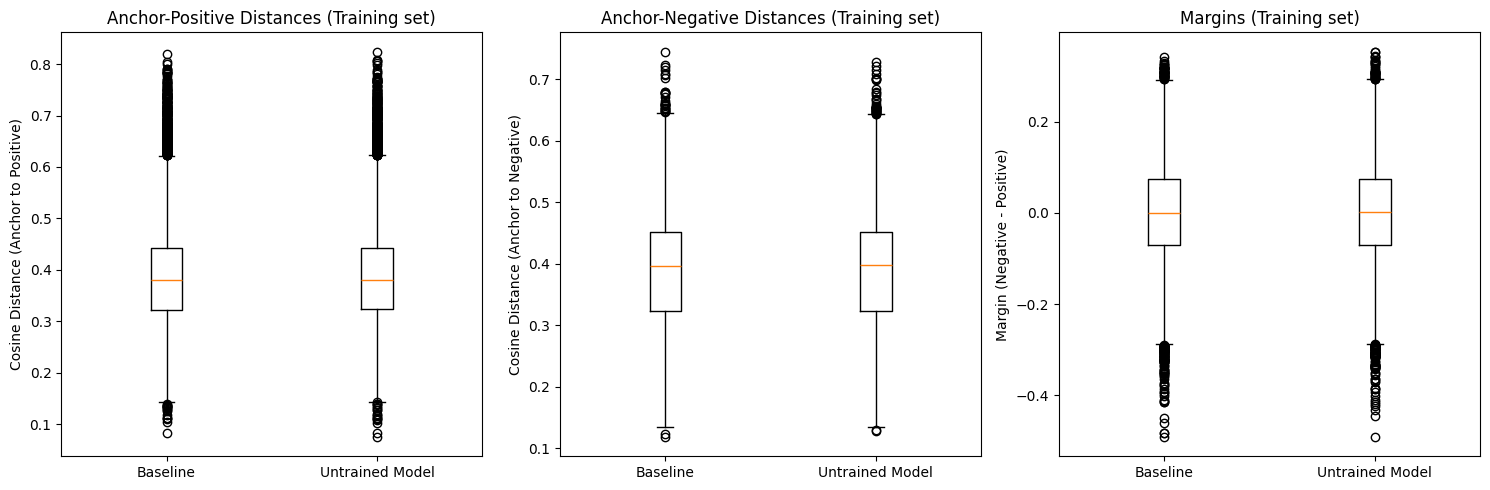

In [7]:
# Check initial similarities in the raw data
ap_distances = []
an_distances = []
margins = []
for anchor, pos, neg in train_ds:
    ap_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), pos.unsqueeze(0)).item()
    an_dist = 1 - F.cosine_similarity(anchor.unsqueeze(0), neg.unsqueeze(0)).item()
    ap_distances.append(ap_dist)
    an_distances.append(an_dist)
    margins.append(an_dist - ap_dist)

print(f"=== BASELINE ===")
print(f"Average Anchor-Positive distance: {np.mean(ap_distances):.4f} ± {np.std(ap_distances):.4f}")
print(f"Average Anchor-Negative distance: {np.mean(an_distances):.4f} ± {np.std(an_distances):.4f}")
print(f"Average margin in baseline data: {np.mean(margins):.4f}")

baseline_results = {"distances_to_positive": ap_distances, "distances_to_negative": an_distances, "margins": margins}
# Baseline loss
with torch.no_grad():
    model.eval()
    train_losses = []
    for anchors, positives, negatives in train_dataloader:
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        anchor_out = model(anchors)
        train_loss = loss_function(anchor_out, positives, negatives)
        train_losses.append(train_loss.item())

    # Check that the untrained model isn't starting from a point where it's perturbing the data far away from positives
    for name, dataset in [("Training", train_ds)]:
        ap_distances_after = []
        an_distances_after = []

        with torch.no_grad():
            for anchor, pos, neg in list(dataset):
                anchor = anchor.to(device).unsqueeze(0)

                anchor_emb = model(anchor)  # Only transform anchor

                # Compare to raw positive/negative (no transformation)
                ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
                an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

                ap_distances_after.append(ap_dist)
                an_distances_after.append(an_dist)

        anchor_positive_mean_distance = np.mean(ap_distances_after)
        anchor_negative_mean_distance = np.mean(an_distances_after)
        ap_pct_diff = ((anchor_positive_mean_distance - np.mean(ap_distances)) / np.mean(ap_distances)) * 100
        an_pct_diff = ((anchor_negative_mean_distance - np.mean(an_distances)) / np.mean(an_distances)) * 100
        print(f"=== UNTRAINED ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
        print(f"Anchor-Positive distance: {anchor_positive_mean_distance:.4f}, {ap_pct_diff:+.4f}% vs. baseline")
        print(f"Anchor-Negative distance: {anchor_negative_mean_distance:.4f}, {an_pct_diff:+.4f}% vs. baseline")
        print(f"Average margin: {anchor_negative_mean_distance - anchor_positive_mean_distance:.4f}")

        if abs(ap_pct_diff) > 5.0:
            print("WARNING: Untrained model is changing Anchor-Positive distances significantly!")
        if abs(an_pct_diff) > 5.0:
            print("WARNING: Untrained model is changing Anchor-Negative distances significantly!")
            
        # Box plot the results
        job['results']['untrained'] = {
            'distances_to_positive': ap_distances_after,
            'distances_to_negative': an_distances_after,
            'margins': [an - ap for ap, an in zip(ap_distances_after, an_distances_after)]
        }
        # Box plot ap_distances against ap_distances_after
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].boxplot([ap_distances, ap_distances_after], tick_labels=['Baseline', 'Untrained Model'])
        axes[0].set_ylabel('Cosine Distance (Anchor to Positive)')
        axes[0].set_title(f"Anchor-Positive Distances ({name} set)")

        axes[1].boxplot([an_distances, an_distances_after], tick_labels=['Baseline', 'Untrained Model'])
        axes[1].set_ylabel('Cosine Distance (Anchor to Negative)')
        axes[1].set_title(f"Anchor-Negative Distances ({name} set)")

        axes[2].boxplot([baseline_results['margins'], job['results']['untrained']['margins']], tick_labels=['Baseline', 'Untrained Model'])
        axes[2].set_ylabel('Margin (Negative - Positive)')
        axes[2].set_title(f"Margins ({name} set)")

        plt.tight_layout()
        plt.show()

In [8]:
# Set up save directory
subdir = experiment_name + time.strftime("_%Y%m%d_%H%M%S")
save_dir = Path(job["config"]["model_name"]) / subdir
save_dir.mkdir(parents=True, exist_ok=True)

train_loss_history = []
val_loss_history = []
pos_dist_weight = 1.0
NUM_EPOCHS = 80
min_val_loss = float("inf")
job['config']['epochs'] = NUM_EPOCHS
for epoch in range(NUM_EPOCHS):
    # ---- Training ----
    model.train()
    train_losses = []
    for batch_idx, (anchors, positives, negatives) in enumerate(train_dataloader):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        optimizer.zero_grad()
        anchor_out = model(anchors)

        loss = loss_function(anchor_out, positives, negatives) 
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss_epoch = np.mean(train_losses)
    train_loss_history.append(train_loss_epoch)

    # ---- Validation ----
    model.eval()
    val_losses = []
    with torch.no_grad():
        for anchors, positives, negatives in val_dataloader:
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            anchor_out = model(anchors)

            loss = loss_function(anchor_out, positives, negatives) 

            val_losses.append(loss.item())

    val_loss_epoch = np.mean(val_losses)
    val_loss_history.append(val_loss_epoch)
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch

        # Save model trace
        sample = torch.randn(1, 1024).to(device)
        trace = torch.jit.trace(model, sample)
        trace_path = save_dir / f"{job['config']['model_name']}_traced.pth"

        torch.jit.save(trace, trace_path)
        job["config"]["model_trace_path"] = str(trace_path)

        with open(save_dir / "results.json", "w") as f:
            json.dump(job, f, indent=2)

    print(f"Epoch {epoch}: Train Loss = {train_loss_epoch:.4f}, Val Loss = {val_loss_epoch:.4f}")

job["results"]["training_loss"] = train_loss_history
job["results"]["validation_loss"] = val_loss_history

Epoch 0: Train Loss = 0.3410, Val Loss = 0.3236
Epoch 1: Train Loss = 0.3214, Val Loss = 0.3207
Epoch 2: Train Loss = 0.3199, Val Loss = 0.3181
Epoch 3: Train Loss = 0.3144, Val Loss = 0.3113
Epoch 4: Train Loss = 0.3081, Val Loss = 0.3056
Epoch 5: Train Loss = 0.3035, Val Loss = 0.3027
Epoch 6: Train Loss = 0.3013, Val Loss = 0.3000
Epoch 7: Train Loss = 0.2995, Val Loss = 0.2991
Epoch 8: Train Loss = 0.2976, Val Loss = 0.2979
Epoch 9: Train Loss = 0.2972, Val Loss = 0.2966
Epoch 10: Train Loss = 0.2960, Val Loss = 0.2962
Epoch 11: Train Loss = 0.2949, Val Loss = 0.2956
Epoch 12: Train Loss = 0.2939, Val Loss = 0.2940
Epoch 13: Train Loss = 0.2931, Val Loss = 0.2929
Epoch 14: Train Loss = 0.2923, Val Loss = 0.2933
Epoch 15: Train Loss = 0.2916, Val Loss = 0.2924
Epoch 16: Train Loss = 0.2908, Val Loss = 0.2916
Epoch 17: Train Loss = 0.2900, Val Loss = 0.2911
Epoch 18: Train Loss = 0.2896, Val Loss = 0.2908
Epoch 19: Train Loss = 0.2889, Val Loss = 0.2903
Epoch 20: Train Loss = 0.2884,

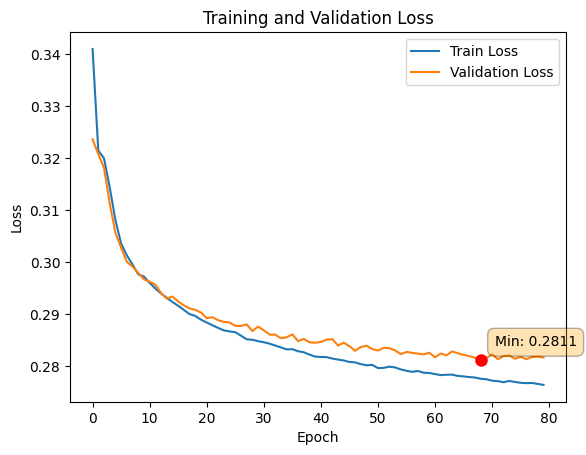

In [9]:
# Plot train and validation loss
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# Add a notation where the minimal val loss occurred and amount
min_val_loss = min(val_loss_history)
min_val_loss_epoch = val_loss_history.index(min_val_loss)

# Mark the point
plt.plot(min_val_loss_epoch, min_val_loss, "ro", markersize=8)

# Add annotation with box
plt.annotate(
    f"Min: {min_val_loss:.4f}",
    xy=(min_val_loss_epoch, min_val_loss),
    xytext=(10, 10),  # Offset in points
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="orange", alpha=0.3),
    # arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
)

plt.title("Training and Validation Loss")
plt.savefig(save_dir / "loss_curve.png")  # Save BEFORE show
plt.show()

=== AFTER TRAINING (Validation set, Anchor mapped, Pos/Neg unchanged) ===
Anchor-Positive distance: 0.2812 ± 0.0577
Anchor-Negative distance: 0.2853 ± 0.0569
Average margin: 0.0041
Learned margin mean: 0.0041 ± 0.0693
Learned margin median: 0.0038
Distribution of margins: min=-0.2856, max=0.3198


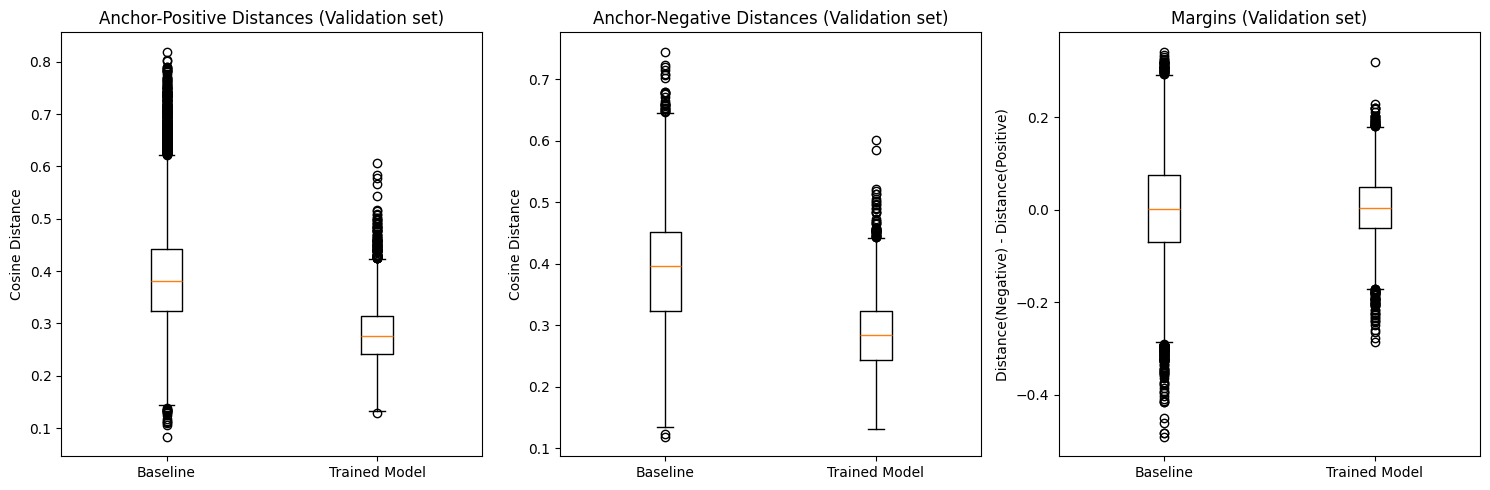

In [10]:
# Side by side boxplots of baseline distances to distances after training
model.eval()
for name, dataset in [("Validation", val_ds)]:
    ap_distances_after = []
    an_distances_after = []

    with torch.no_grad():
        for anchor, pos, neg in list(dataset):
            anchor = anchor.to(device).unsqueeze(0)

            anchor_emb = model(anchor)  # Only transform anchor

            # Compare to raw positive/negative (no transformation)
            ap_dist = 1 - F.cosine_similarity(anchor_emb, pos.unsqueeze(0).to(device)).item()
            an_dist = 1 - F.cosine_similarity(anchor_emb, neg.unsqueeze(0).to(device)).item()

            ap_distances_after.append(ap_dist)
            an_distances_after.append(an_dist)

    anchor_positive_mean_distance = np.mean(ap_distances_after)
    anchor_negative_mean_distance = np.mean(an_distances_after)
    margins_trained = [an - ap for ap, an in zip(ap_distances_after, an_distances_after)]
    print(f"=== AFTER TRAINING ({name} set, Anchor mapped, Pos/Neg unchanged) ===")
    print(f"Anchor-Positive distance: {anchor_positive_mean_distance:.4f} ± {np.std(ap_distances_after):.4f}")
    print(f"Anchor-Negative distance: {anchor_negative_mean_distance:.4f} ± {np.std(an_distances_after):.4f}")
    print(f"Average margin: {anchor_negative_mean_distance - anchor_positive_mean_distance:.4f}")
    print(f"Learned margin mean: {np.mean(margins_trained):.4f} ± {np.std(margins_trained):.4f}")
    print(f"Learned margin median: {np.median(margins_trained):.4f}")
    print(f"Distribution of margins: min={np.min(margins_trained):.4f}, max={np.max(margins_trained):.4f}")

    # Box plot the results
    job['results']['trained'] = {
        'distances_to_positive': ap_distances_after,
        'distances_to_negative': an_distances_after,
        'margins': [an - ap for ap, an in zip(ap_distances_after, an_distances_after)]
    }
    # Box plot ap_distances against ap_distances_after
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].boxplot([baseline_results['distances_to_positive'], job['results']['trained']['distances_to_positive']], tick_labels=['Baseline', 'Trained Model'])
    axes[0].set_ylabel('Cosine Distance')
    axes[0].set_title(f"Anchor-Positive Distances ({name} set)")

    axes[1].boxplot([baseline_results['distances_to_negative'], job['results']['trained']['distances_to_negative']], tick_labels=['Baseline', 'Trained Model'])
    axes[1].set_ylabel('Cosine Distance')
    axes[1].set_title(f"Anchor-Negative Distances ({name} set)")

    axes[2].boxplot([baseline_results['margins'], job['results']['trained']['margins']], tick_labels=['Baseline', 'Trained Model'])
    axes[2].set_ylabel('Distance(Negative) - Distance(Positive)')
    axes[2].set_title(f"Margins ({name} set)")

    plt.tight_layout()
    plt.savefig(save_dir / "val_distances_boxplot.png")  # Save BEFORE show
    plt.show()

In [11]:
import sys
project_root = Path.cwd().parent  # Goes up from notebooks/ to project root
sys.path.insert(0, str(project_root))
from experiment import Experiment

experiment_config = {
    "dataset": "../data/dataset/nn/val_ds_add_prev_2.jsonl",
    "table": "qwen06_chunks",
    "target_column": "vector",
    "metric": "IP",
    "embedder": "Qwen/Qwen3-Embedding-0.6B",
    "normalize": True,
    "nn": job['config']['model_trace_path'],
    "strategy": 'multiple_query_expansion',
    "query_expanders": ["add_prev_2"],
    "interleave": True,
    "batch_size": 16,
    "top_k": 1000,
    "output_path": "../experiments/nn/results/",
    "output_search_results": False,
    "plot_label": experiment_name
}
experiment = Experiment(**experiment_config)
experiment.run()

==================== Experiment Configuration ====================
dataset: ../data/dataset/nn/val_ds_add_prev_2.jsonl
table: qwen06_chunks
target_column: vector
metric: IP
embedder: Qwen/Qwen3-Embedding-0.6B
normalize: True
nn: BaselineEmbeddingMapper/cos_adam_80epochs_20251030_111232/BaselineEmbeddingMapper_traced.pth
strategy: multiple_query_expansion
query_expanders: ['add_prev_2']
interleave: True
batch_size: 16
top_k: 1000
output_path: ../experiments/nn/results/
output_search_results: False
plot_label: cos_adam_80epochs

Collection qwen06_chunks loaded.
Starting 11 database query workers


Embedding (GPU):   0%|          | 0/5640 [00:00<?, ?it/s]

Applying neural network model to batch starting at index 0
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   0%|          | 16/5640 [00:03<18:43,  5.01it/s]

Applying neural network model to batch starting at index 16
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   1%|          | 32/5640 [00:04<12:19,  7.58it/s]

Applying neural network model to batch starting at index 32
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   1%|          | 48/5640 [00:06<10:54,  8.55it/s]

Applying neural network model to batch starting at index 48
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   1%|          | 64/5640 [00:08<11:44,  7.91it/s]

Applying neural network model to batch starting at index 64
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   1%|▏         | 80/5640 [00:10<10:54,  8.50it/s]

Applying neural network model to batch starting at index 80
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   2%|▏         | 96/5640 [00:12<11:06,  8.32it/s]

Applying neural network model to batch starting at index 96
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   2%|▏         | 112/5640 [00:14<12:00,  7.67it/s]

Applying neural network model to batch starting at index 112
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   2%|▏         | 128/5640 [00:16<11:58,  7.67it/s]

Applying neural network model to batch starting at index 128
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   3%|▎         | 144/5640 [00:20<14:48,  6.18it/s]

Applying neural network model to batch starting at index 144
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   3%|▎         | 160/5640 [00:21<13:17,  6.87it/s]

Applying neural network model to batch starting at index 160
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   3%|▎         | 176/5640 [00:23<12:11,  7.47it/s]

Applying neural network model to batch starting at index 176
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   3%|▎         | 192/5640 [00:25<11:43,  7.74it/s]

Applying neural network model to batch starting at index 192
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   4%|▎         | 208/5640 [00:27<10:35,  8.54it/s]

Applying neural network model to batch starting at index 208
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   4%|▍         | 224/5640 [00:28<10:39,  8.47it/s]

Applying neural network model to batch starting at index 224
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   4%|▍         | 240/5640 [00:31<12:25,  7.25it/s]

Applying neural network model to batch starting at index 240
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   5%|▍         | 256/5640 [00:33<11:36,  7.73it/s]

Applying neural network model to batch starting at index 256
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   5%|▍         | 272/5640 [00:35<10:58,  8.15it/s]

Applying neural network model to batch starting at index 272
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   5%|▌         | 288/5640 [00:37<10:45,  8.29it/s]

Applying neural network model to batch starting at index 288
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   5%|▌         | 304/5640 [00:39<10:50,  8.21it/s]

Applying neural network model to batch starting at index 304
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   6%|▌         | 320/5640 [00:41<11:14,  7.88it/s]

Applying neural network model to batch starting at index 320
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   6%|▌         | 336/5640 [00:43<11:23,  7.76it/s]

Applying neural network model to batch starting at index 336
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   6%|▌         | 352/5640 [00:45<11:38,  7.57it/s]

Applying neural network model to batch starting at index 352
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   7%|▋         | 368/5640 [00:47<11:21,  7.74it/s]

Applying neural network model to batch starting at index 368
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   7%|▋         | 384/5640 [00:51<13:23,  6.54it/s]

Applying neural network model to batch starting at index 384
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   7%|▋         | 400/5640 [00:53<13:19,  6.55it/s]

Applying neural network model to batch starting at index 400
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   7%|▋         | 416/5640 [00:55<13:10,  6.61it/s]

Applying neural network model to batch starting at index 416
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   8%|▊         | 432/5640 [00:58<13:07,  6.61it/s]

Applying neural network model to batch starting at index 432
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   8%|▊         | 448/5640 [01:00<12:14,  7.07it/s]

Applying neural network model to batch starting at index 448
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   8%|▊         | 464/5640 [01:03<13:49,  6.24it/s]

Applying neural network model to batch starting at index 464
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   9%|▊         | 480/5640 [01:05<13:36,  6.32it/s]

Applying neural network model to batch starting at index 480
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   9%|▉         | 496/5640 [01:08<12:52,  6.66it/s]

Applying neural network model to batch starting at index 496
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   9%|▉         | 512/5640 [01:09<11:57,  7.14it/s]

Applying neural network model to batch starting at index 512
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):   9%|▉         | 528/5640 [01:12<12:09,  7.00it/s]

Applying neural network model to batch starting at index 528
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  10%|▉         | 544/5640 [01:13<11:06,  7.65it/s]

Applying neural network model to batch starting at index 544
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  10%|▉         | 560/5640 [01:17<13:42,  6.18it/s]

Applying neural network model to batch starting at index 560
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  10%|█         | 576/5640 [01:19<12:46,  6.61it/s]

Applying neural network model to batch starting at index 576
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  10%|█         | 592/5640 [01:21<11:27,  7.34it/s]

Applying neural network model to batch starting at index 592
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  11%|█         | 608/5640 [01:23<11:34,  7.25it/s]

Applying neural network model to batch starting at index 608
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  11%|█         | 624/5640 [01:25<10:29,  7.97it/s]

Applying neural network model to batch starting at index 624
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  11%|█▏        | 640/5640 [01:27<10:42,  7.79it/s]

Applying neural network model to batch starting at index 640
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  12%|█▏        | 656/5640 [01:28<10:00,  8.30it/s]

Applying neural network model to batch starting at index 656
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  12%|█▏        | 672/5640 [01:31<10:58,  7.54it/s]

Applying neural network model to batch starting at index 672
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  12%|█▏        | 688/5640 [01:33<10:39,  7.74it/s]

Applying neural network model to batch starting at index 688
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  12%|█▏        | 704/5640 [01:35<10:09,  8.10it/s]

Applying neural network model to batch starting at index 704
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  13%|█▎        | 720/5640 [01:38<11:36,  7.06it/s]

Applying neural network model to batch starting at index 720
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  13%|█▎        | 736/5640 [01:41<12:33,  6.51it/s]

Applying neural network model to batch starting at index 736
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  13%|█▎        | 752/5640 [01:42<11:39,  6.99it/s]

Applying neural network model to batch starting at index 752
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  14%|█▎        | 768/5640 [01:45<12:14,  6.63it/s]

Applying neural network model to batch starting at index 768
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  14%|█▍        | 784/5640 [01:47<10:57,  7.38it/s]

Applying neural network model to batch starting at index 784
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  14%|█▍        | 800/5640 [01:48<10:16,  7.85it/s]

Applying neural network model to batch starting at index 800
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  14%|█▍        | 816/5640 [01:52<12:32,  6.41it/s]

Applying neural network model to batch starting at index 816
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  15%|█▍        | 832/5640 [01:53<10:46,  7.43it/s]

Applying neural network model to batch starting at index 832
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  15%|█▌        | 848/5640 [01:55<10:27,  7.64it/s]

Applying neural network model to batch starting at index 848
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  15%|█▌        | 864/5640 [01:58<11:25,  6.96it/s]

Applying neural network model to batch starting at index 864
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  16%|█▌        | 880/5640 [02:00<10:44,  7.39it/s]

Applying neural network model to batch starting at index 880
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  16%|█▌        | 896/5640 [02:02<10:17,  7.68it/s]

Applying neural network model to batch starting at index 896
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  16%|█▌        | 912/5640 [02:04<10:07,  7.79it/s]

Applying neural network model to batch starting at index 912
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  16%|█▋        | 928/5640 [02:07<11:02,  7.11it/s]

Applying neural network model to batch starting at index 928
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  17%|█▋        | 944/5640 [02:09<10:49,  7.23it/s]

Applying neural network model to batch starting at index 944
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  17%|█▋        | 960/5640 [02:11<11:23,  6.85it/s]

Applying neural network model to batch starting at index 960
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  17%|█▋        | 976/5640 [02:14<11:37,  6.68it/s]

Applying neural network model to batch starting at index 976
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  18%|█▊        | 992/5640 [02:15<10:18,  7.52it/s]

Applying neural network model to batch starting at index 992
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  18%|█▊        | 1008/5640 [02:18<10:29,  7.36it/s]

Applying neural network model to batch starting at index 1008
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  18%|█▊        | 1024/5640 [02:20<10:28,  7.34it/s]

Applying neural network model to batch starting at index 1024
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  18%|█▊        | 1040/5640 [02:23<11:13,  6.83it/s]

Applying neural network model to batch starting at index 1040
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  19%|█▊        | 1056/5640 [02:24<09:24,  8.12it/s]

Applying neural network model to batch starting at index 1056
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  19%|█▉        | 1072/5640 [02:25<09:08,  8.33it/s]

Applying neural network model to batch starting at index 1072
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  19%|█▉        | 1088/5640 [02:28<09:29,  7.99it/s]

Applying neural network model to batch starting at index 1088
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  20%|█▉        | 1104/5640 [02:30<09:59,  7.57it/s]

Applying neural network model to batch starting at index 1104
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  20%|█▉        | 1120/5640 [02:32<10:15,  7.35it/s]

Applying neural network model to batch starting at index 1120
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  20%|██        | 1136/5640 [02:34<08:52,  8.45it/s]

Applying neural network model to batch starting at index 1136
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  20%|██        | 1152/5640 [02:36<09:16,  8.06it/s]

Applying neural network model to batch starting at index 1152
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  21%|██        | 1168/5640 [02:37<08:51,  8.42it/s]

Applying neural network model to batch starting at index 1168
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  21%|██        | 1184/5640 [02:42<12:07,  6.12it/s]

Applying neural network model to batch starting at index 1184
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  21%|██▏       | 1200/5640 [02:44<11:12,  6.60it/s]

Applying neural network model to batch starting at index 1200
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  22%|██▏       | 1216/5640 [02:47<11:38,  6.33it/s]

Applying neural network model to batch starting at index 1216
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  22%|██▏       | 1232/5640 [02:48<10:30,  7.00it/s]

Applying neural network model to batch starting at index 1232
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  22%|██▏       | 1248/5640 [02:50<10:07,  7.23it/s]

Applying neural network model to batch starting at index 1248
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  22%|██▏       | 1264/5640 [02:53<10:52,  6.71it/s]

Applying neural network model to batch starting at index 1264
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  23%|██▎       | 1280/5640 [02:56<12:02,  6.04it/s]

Applying neural network model to batch starting at index 1280
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  23%|██▎       | 1296/5640 [02:58<11:01,  6.56it/s]

Applying neural network model to batch starting at index 1296
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  23%|██▎       | 1312/5640 [03:00<10:39,  6.77it/s]

Applying neural network model to batch starting at index 1312
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  24%|██▎       | 1328/5640 [03:02<09:58,  7.20it/s]

Applying neural network model to batch starting at index 1328
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  24%|██▍       | 1344/5640 [03:05<10:54,  6.56it/s]

Applying neural network model to batch starting at index 1344
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  24%|██▍       | 1360/5640 [03:09<12:20,  5.78it/s]

Applying neural network model to batch starting at index 1360
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  24%|██▍       | 1376/5640 [03:11<12:03,  5.90it/s]

Applying neural network model to batch starting at index 1376
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  25%|██▍       | 1392/5640 [03:13<10:33,  6.71it/s]

Applying neural network model to batch starting at index 1392
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  25%|██▍       | 1408/5640 [03:15<09:58,  7.07it/s]

Applying neural network model to batch starting at index 1408
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  25%|██▌       | 1424/5640 [03:17<09:05,  7.73it/s]

Applying neural network model to batch starting at index 1424
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  26%|██▌       | 1440/5640 [03:19<09:09,  7.64it/s]

Applying neural network model to batch starting at index 1440
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  26%|██▌       | 1456/5640 [03:21<09:27,  7.38it/s]

Applying neural network model to batch starting at index 1456
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  26%|██▌       | 1472/5640 [03:23<09:38,  7.20it/s]

Applying neural network model to batch starting at index 1472
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  26%|██▋       | 1488/5640 [03:25<08:54,  7.77it/s]

Applying neural network model to batch starting at index 1488
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  27%|██▋       | 1504/5640 [03:28<09:57,  6.92it/s]

Applying neural network model to batch starting at index 1504
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  27%|██▋       | 1520/5640 [03:30<09:43,  7.06it/s]

Applying neural network model to batch starting at index 1520
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  27%|██▋       | 1536/5640 [03:32<09:06,  7.50it/s]

Applying neural network model to batch starting at index 1536
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  28%|██▊       | 1552/5640 [03:34<09:02,  7.53it/s]

Applying neural network model to batch starting at index 1552
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  28%|██▊       | 1568/5640 [03:37<10:29,  6.47it/s]

Applying neural network model to batch starting at index 1568
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  28%|██▊       | 1584/5640 [03:40<10:30,  6.43it/s]

Applying neural network model to batch starting at index 1584
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  28%|██▊       | 1600/5640 [03:42<09:56,  6.78it/s]

Applying neural network model to batch starting at index 1600
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  29%|██▊       | 1616/5640 [03:44<09:49,  6.83it/s]

Applying neural network model to batch starting at index 1616
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  29%|██▉       | 1632/5640 [03:46<08:57,  7.45it/s]

Applying neural network model to batch starting at index 1632
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  29%|██▉       | 1648/5640 [03:49<10:06,  6.59it/s]

Applying neural network model to batch starting at index 1648
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  30%|██▉       | 1664/5640 [03:52<11:04,  5.99it/s]

Applying neural network model to batch starting at index 1664
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  30%|██▉       | 1680/5640 [03:54<10:19,  6.39it/s]

Applying neural network model to batch starting at index 1680
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  30%|███       | 1696/5640 [03:56<09:15,  7.09it/s]

Applying neural network model to batch starting at index 1696
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  30%|███       | 1712/5640 [03:59<09:47,  6.68it/s]

Applying neural network model to batch starting at index 1712
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  31%|███       | 1728/5640 [04:00<08:40,  7.51it/s]

Applying neural network model to batch starting at index 1728
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  31%|███       | 1744/5640 [04:02<07:54,  8.22it/s]

Applying neural network model to batch starting at index 1744
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  31%|███       | 1760/5640 [04:04<07:33,  8.56it/s]

Applying neural network model to batch starting at index 1760
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  31%|███▏      | 1776/5640 [04:07<09:03,  7.11it/s]

Applying neural network model to batch starting at index 1776
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  32%|███▏      | 1792/5640 [04:09<08:56,  7.17it/s]

Applying neural network model to batch starting at index 1792
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  32%|███▏      | 1808/5640 [04:12<09:37,  6.64it/s]

Applying neural network model to batch starting at index 1808
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  32%|███▏      | 1824/5640 [04:15<10:47,  5.89it/s]

Applying neural network model to batch starting at index 1824
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  33%|███▎      | 1840/5640 [04:19<11:53,  5.33it/s]

Applying neural network model to batch starting at index 1840
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  33%|███▎      | 1856/5640 [04:20<09:45,  6.47it/s]

Applying neural network model to batch starting at index 1856
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  33%|███▎      | 1872/5640 [04:22<08:40,  7.23it/s]

Applying neural network model to batch starting at index 1872
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  33%|███▎      | 1888/5640 [04:23<07:35,  8.23it/s]

Applying neural network model to batch starting at index 1888
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  34%|███▍      | 1904/5640 [04:24<06:42,  9.29it/s]

Applying neural network model to batch starting at index 1904
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  34%|███▍      | 1920/5640 [04:26<06:29,  9.55it/s]

Applying neural network model to batch starting at index 1920
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  34%|███▍      | 1936/5640 [04:27<06:09, 10.03it/s]

Applying neural network model to batch starting at index 1936
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  35%|███▍      | 1952/5640 [04:29<05:50, 10.51it/s]

Applying neural network model to batch starting at index 1952
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  35%|███▍      | 1968/5640 [04:32<08:16,  7.39it/s]

Applying neural network model to batch starting at index 1968
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  35%|███▌      | 1984/5640 [04:35<08:34,  7.11it/s]

Applying neural network model to batch starting at index 1984
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  35%|███▌      | 2000/5640 [04:37<08:17,  7.32it/s]

Applying neural network model to batch starting at index 2000
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  36%|███▌      | 2016/5640 [04:38<07:33,  8.00it/s]

Applying neural network model to batch starting at index 2016
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  36%|███▌      | 2032/5640 [04:40<07:18,  8.23it/s]

Applying neural network model to batch starting at index 2032
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  36%|███▋      | 2048/5640 [04:42<07:40,  7.80it/s]

Applying neural network model to batch starting at index 2048
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  37%|███▋      | 2064/5640 [04:45<08:25,  7.07it/s]

Applying neural network model to batch starting at index 2064
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  37%|███▋      | 2080/5640 [04:52<13:24,  4.43it/s]

Applying neural network model to batch starting at index 2080
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  37%|███▋      | 2096/5640 [04:55<12:21,  4.78it/s]

Applying neural network model to batch starting at index 2096
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  37%|███▋      | 2112/5640 [04:58<12:05,  4.87it/s]

Applying neural network model to batch starting at index 2112
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  38%|███▊      | 2128/5640 [04:59<10:15,  5.71it/s]

Applying neural network model to batch starting at index 2128
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  38%|███▊      | 2144/5640 [05:01<08:35,  6.79it/s]

Applying neural network model to batch starting at index 2144
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  38%|███▊      | 2160/5640 [05:02<07:28,  7.75it/s]

Applying neural network model to batch starting at index 2160
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  39%|███▊      | 2176/5640 [05:03<06:36,  8.74it/s]

Applying neural network model to batch starting at index 2176
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  39%|███▉      | 2192/5640 [05:05<05:59,  9.60it/s]

Applying neural network model to batch starting at index 2192
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  39%|███▉      | 2208/5640 [05:06<05:43,  9.99it/s]

Applying neural network model to batch starting at index 2208
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  39%|███▉      | 2224/5640 [05:10<07:47,  7.30it/s]

Applying neural network model to batch starting at index 2224
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  40%|███▉      | 2240/5640 [05:11<07:02,  8.05it/s]

Applying neural network model to batch starting at index 2240
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  40%|████      | 2256/5640 [05:13<07:01,  8.03it/s]

Applying neural network model to batch starting at index 2256
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  40%|████      | 2272/5640 [05:15<06:15,  8.96it/s]

Applying neural network model to batch starting at index 2272
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  41%|████      | 2288/5640 [05:18<07:30,  7.44it/s]

Applying neural network model to batch starting at index 2288
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  41%|████      | 2304/5640 [05:20<07:31,  7.40it/s]

Applying neural network model to batch starting at index 2304
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  41%|████      | 2320/5640 [05:22<07:48,  7.08it/s]

Applying neural network model to batch starting at index 2320
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  41%|████▏     | 2336/5640 [05:24<07:26,  7.41it/s]

Applying neural network model to batch starting at index 2336
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  42%|████▏     | 2352/5640 [05:31<12:28,  4.39it/s]

Applying neural network model to batch starting at index 2352
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  42%|████▏     | 2368/5640 [05:36<13:44,  3.97it/s]

Applying neural network model to batch starting at index 2368
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  42%|████▏     | 2384/5640 [05:39<12:26,  4.36it/s]

Applying neural network model to batch starting at index 2384
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  43%|████▎     | 2400/5640 [05:41<10:19,  5.23it/s]

Applying neural network model to batch starting at index 2400
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  43%|████▎     | 2416/5640 [05:43<09:49,  5.47it/s]

Applying neural network model to batch starting at index 2416
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  43%|████▎     | 2432/5640 [05:45<08:46,  6.10it/s]

Applying neural network model to batch starting at index 2432
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  43%|████▎     | 2448/5640 [05:47<08:20,  6.38it/s]

Applying neural network model to batch starting at index 2448
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  44%|████▎     | 2464/5640 [06:42<59:34,  1.13s/it]

Applying neural network model to batch starting at index 2464
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  44%|████▍     | 2480/5640 [06:45<44:32,  1.18it/s]

Applying neural network model to batch starting at index 2480
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  44%|████▍     | 2496/5640 [06:47<33:04,  1.58it/s]

Applying neural network model to batch starting at index 2496
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  45%|████▍     | 2512/5640 [07:02<37:38,  1.38it/s]

Applying neural network model to batch starting at index 2512
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  45%|████▍     | 2528/5640 [07:04<28:41,  1.81it/s]

Applying neural network model to batch starting at index 2528
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  45%|████▌     | 2544/5640 [07:09<25:01,  2.06it/s]

Applying neural network model to batch starting at index 2544
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  45%|████▌     | 2560/5640 [07:11<19:11,  2.67it/s]

Applying neural network model to batch starting at index 2560
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  46%|████▌     | 2576/5640 [07:14<15:44,  3.24it/s]

Applying neural network model to batch starting at index 2576
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  46%|████▌     | 2592/5640 [07:17<13:36,  3.73it/s]

Applying neural network model to batch starting at index 2592
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  46%|████▌     | 2608/5640 [07:18<10:59,  4.59it/s]

Applying neural network model to batch starting at index 2608
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  47%|████▋     | 2624/5640 [07:20<09:05,  5.53it/s]

Applying neural network model to batch starting at index 2624
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  47%|████▋     | 2640/5640 [07:21<07:28,  6.70it/s]

Applying neural network model to batch starting at index 2640
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  47%|████▋     | 2656/5640 [07:22<06:18,  7.88it/s]

Applying neural network model to batch starting at index 2656
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  47%|████▋     | 2672/5640 [07:24<06:33,  7.54it/s]

Applying neural network model to batch starting at index 2672
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  48%|████▊     | 2688/5640 [07:28<08:09,  6.03it/s]

Applying neural network model to batch starting at index 2688
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  48%|████▊     | 2704/5640 [07:32<08:39,  5.65it/s]

Applying neural network model to batch starting at index 2704
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  48%|████▊     | 2720/5640 [15:05<6:59:49,  8.63s/it]

Applying neural network model to batch starting at index 2720
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  49%|████▊     | 2736/5640 [15:10<4:56:45,  6.13s/it]

Applying neural network model to batch starting at index 2736
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  49%|████▉     | 2752/5640 [15:12<3:28:41,  4.34s/it]

Applying neural network model to batch starting at index 2752
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  49%|████▉     | 2768/5640 [15:17<2:29:18,  3.12s/it]

Applying neural network model to batch starting at index 2768
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  49%|████▉     | 2784/5640 [15:19<1:45:56,  2.23s/it]

Applying neural network model to batch starting at index 2784
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  50%|████▉     | 2800/5640 [15:21<1:15:35,  1.60s/it]

Applying neural network model to batch starting at index 2800
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  50%|████▉     | 2816/5640 [15:24<54:49,  1.16s/it]  

Applying neural network model to batch starting at index 2816
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  50%|█████     | 2832/5640 [15:25<39:26,  1.19it/s]

Applying neural network model to batch starting at index 2832
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  50%|█████     | 2848/5640 [15:28<30:03,  1.55it/s]

Applying neural network model to batch starting at index 2848
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  51%|█████     | 2864/5640 [15:32<23:55,  1.93it/s]

Applying neural network model to batch starting at index 2864
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  51%|█████     | 2880/5640 [15:34<18:27,  2.49it/s]

Applying neural network model to batch starting at index 2880
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  51%|█████▏    | 2896/5640 [15:35<13:50,  3.30it/s]

Applying neural network model to batch starting at index 2896
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  52%|█████▏    | 2912/5640 [15:37<11:10,  4.07it/s]

Applying neural network model to batch starting at index 2912
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  52%|█████▏    | 2928/5640 [15:39<09:48,  4.61it/s]

Applying neural network model to batch starting at index 2928
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  52%|█████▏    | 2944/5640 [15:41<08:12,  5.47it/s]

Applying neural network model to batch starting at index 2944
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  52%|█████▏    | 2960/5640 [15:42<07:10,  6.23it/s]

Applying neural network model to batch starting at index 2960
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  53%|█████▎    | 2976/5640 [15:44<06:03,  7.33it/s]

Applying neural network model to batch starting at index 2976
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  53%|█████▎    | 2992/5640 [15:46<06:24,  6.89it/s]

Applying neural network model to batch starting at index 2992
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  53%|█████▎    | 3008/5640 [15:49<06:16,  7.00it/s]

Applying neural network model to batch starting at index 3008
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  54%|█████▎    | 3024/5640 [15:54<08:32,  5.11it/s]

Applying neural network model to batch starting at index 3024
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  54%|█████▍    | 3040/5640 [15:56<07:59,  5.42it/s]

Applying neural network model to batch starting at index 3040
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  54%|█████▍    | 3056/5640 [15:58<06:55,  6.22it/s]

Applying neural network model to batch starting at index 3056
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  54%|█████▍    | 3072/5640 [16:01<07:06,  6.02it/s]

Applying neural network model to batch starting at index 3072
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  55%|█████▍    | 3088/5640 [16:05<08:38,  4.93it/s]

Applying neural network model to batch starting at index 3088
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  55%|█████▌    | 3104/5640 [16:09<08:54,  4.75it/s]

Applying neural network model to batch starting at index 3104
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  55%|█████▌    | 3120/5640 [16:12<08:57,  4.69it/s]

Applying neural network model to batch starting at index 3120
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  56%|█████▌    | 3136/5640 [16:14<07:43,  5.41it/s]

Applying neural network model to batch starting at index 3136
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  56%|█████▌    | 3152/5640 [16:19<09:11,  4.51it/s]

Applying neural network model to batch starting at index 3152
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  56%|█████▌    | 3168/5640 [16:21<07:40,  5.36it/s]

Applying neural network model to batch starting at index 3168
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  56%|█████▋    | 3184/5640 [16:24<07:21,  5.57it/s]

Applying neural network model to batch starting at index 3184
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  57%|█████▋    | 3200/5640 [16:26<06:48,  5.97it/s]

Applying neural network model to batch starting at index 3200
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  57%|█████▋    | 3216/5640 [16:31<08:16,  4.88it/s]

Applying neural network model to batch starting at index 3216
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  57%|█████▋    | 3232/5640 [16:33<07:40,  5.22it/s]

Applying neural network model to batch starting at index 3232
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  58%|█████▊    | 3248/5640 [16:36<07:32,  5.28it/s]

Applying neural network model to batch starting at index 3248
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  58%|█████▊    | 3264/5640 [16:38<06:43,  5.89it/s]

Applying neural network model to batch starting at index 3264
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  58%|█████▊    | 3280/5640 [16:39<05:43,  6.88it/s]

Applying neural network model to batch starting at index 3280
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  58%|█████▊    | 3296/5640 [16:42<06:00,  6.50it/s]

Applying neural network model to batch starting at index 3296
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  59%|█████▊    | 3312/5640 [16:45<06:01,  6.44it/s]

Applying neural network model to batch starting at index 3312
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  59%|█████▉    | 3328/5640 [16:49<07:02,  5.47it/s]

Applying neural network model to batch starting at index 3328
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  59%|█████▉    | 3344/5640 [16:50<05:58,  6.40it/s]

Applying neural network model to batch starting at index 3344
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  60%|█████▉    | 3360/5640 [16:53<05:56,  6.40it/s]

Applying neural network model to batch starting at index 3360
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  60%|█████▉    | 3376/5640 [16:54<04:55,  7.66it/s]

Applying neural network model to batch starting at index 3376
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  60%|██████    | 3392/5640 [16:56<04:46,  7.85it/s]

Applying neural network model to batch starting at index 3392
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  60%|██████    | 3408/5640 [16:58<04:53,  7.60it/s]

Applying neural network model to batch starting at index 3408
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  61%|██████    | 3424/5640 [17:00<04:48,  7.69it/s]

Applying neural network model to batch starting at index 3424
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  61%|██████    | 3440/5640 [17:03<05:24,  6.77it/s]

Applying neural network model to batch starting at index 3440
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  61%|██████▏   | 3456/5640 [17:04<04:44,  7.67it/s]

Applying neural network model to batch starting at index 3456
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  62%|██████▏   | 3472/5640 [17:06<04:16,  8.44it/s]

Applying neural network model to batch starting at index 3472
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  62%|██████▏   | 3488/5640 [17:09<05:13,  6.87it/s]

Applying neural network model to batch starting at index 3488
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  62%|██████▏   | 3504/5640 [17:11<04:38,  7.66it/s]

Applying neural network model to batch starting at index 3504
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  62%|██████▏   | 3520/5640 [17:13<04:52,  7.25it/s]

Applying neural network model to batch starting at index 3520
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  63%|██████▎   | 3536/5640 [17:15<04:25,  7.94it/s]

Applying neural network model to batch starting at index 3536
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  63%|██████▎   | 3552/5640 [17:19<05:33,  6.26it/s]

Applying neural network model to batch starting at index 3552
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  63%|██████▎   | 3568/5640 [17:20<04:47,  7.20it/s]

Applying neural network model to batch starting at index 3568
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  64%|██████▎   | 3584/5640 [17:22<04:28,  7.66it/s]

Applying neural network model to batch starting at index 3584
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  64%|██████▍   | 3600/5640 [17:24<04:43,  7.20it/s]

Applying neural network model to batch starting at index 3600
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  64%|██████▍   | 3616/5640 [17:29<05:52,  5.74it/s]

Applying neural network model to batch starting at index 3616
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  64%|██████▍   | 3632/5640 [17:32<06:14,  5.36it/s]

Applying neural network model to batch starting at index 3632
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  65%|██████▍   | 3648/5640 [17:34<05:52,  5.65it/s]

Applying neural network model to batch starting at index 3648
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  65%|██████▍   | 3664/5640 [17:36<05:16,  6.24it/s]

Applying neural network model to batch starting at index 3664
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  65%|██████▌   | 3680/5640 [17:38<04:26,  7.36it/s]

Applying neural network model to batch starting at index 3680
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  66%|██████▌   | 3696/5640 [17:39<04:09,  7.79it/s]

Applying neural network model to batch starting at index 3696
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  66%|██████▌   | 3712/5640 [17:42<04:22,  7.34it/s]

Applying neural network model to batch starting at index 3712
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  66%|██████▌   | 3728/5640 [17:46<05:16,  6.04it/s]

Applying neural network model to batch starting at index 3728
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  66%|██████▋   | 3744/5640 [17:47<04:24,  7.17it/s]

Applying neural network model to batch starting at index 3744
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  67%|██████▋   | 3760/5640 [17:48<03:53,  8.06it/s]

Applying neural network model to batch starting at index 3760
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  67%|██████▋   | 3776/5640 [17:50<03:36,  8.61it/s]

Applying neural network model to batch starting at index 3776
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  67%|██████▋   | 3792/5640 [17:52<03:31,  8.72it/s]

Applying neural network model to batch starting at index 3792
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  68%|██████▊   | 3808/5640 [17:55<04:21,  7.00it/s]

Applying neural network model to batch starting at index 3808
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  68%|██████▊   | 3824/5640 [17:56<03:50,  7.89it/s]

Applying neural network model to batch starting at index 3824
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  68%|██████▊   | 3840/5640 [17:58<03:28,  8.64it/s]

Applying neural network model to batch starting at index 3840
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  68%|██████▊   | 3856/5640 [17:59<03:10,  9.37it/s]

Applying neural network model to batch starting at index 3856
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  69%|██████▊   | 3872/5640 [18:01<03:03,  9.66it/s]

Applying neural network model to batch starting at index 3872
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  69%|██████▉   | 3888/5640 [18:05<04:12,  6.93it/s]

Applying neural network model to batch starting at index 3888
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  69%|██████▉   | 3904/5640 [18:06<03:39,  7.92it/s]

Applying neural network model to batch starting at index 3904
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  70%|██████▉   | 3920/5640 [18:07<03:18,  8.68it/s]

Applying neural network model to batch starting at index 3920
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  70%|██████▉   | 3936/5640 [18:11<04:18,  6.58it/s]

Applying neural network model to batch starting at index 3936
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  70%|███████   | 3952/5640 [18:13<04:06,  6.84it/s]

Applying neural network model to batch starting at index 3952
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  70%|███████   | 3968/5640 [18:15<03:37,  7.71it/s]

Applying neural network model to batch starting at index 3968
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  71%|███████   | 3984/5640 [18:16<03:12,  8.62it/s]

Applying neural network model to batch starting at index 3984
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  71%|███████   | 4000/5640 [18:20<04:04,  6.72it/s]

Applying neural network model to batch starting at index 4000
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  71%|███████   | 4016/5640 [18:21<03:42,  7.30it/s]

Applying neural network model to batch starting at index 4016
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  71%|███████▏  | 4032/5640 [18:23<03:27,  7.74it/s]

Applying neural network model to batch starting at index 4032
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  72%|███████▏  | 4048/5640 [18:25<03:24,  7.77it/s]

Applying neural network model to batch starting at index 4048
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  72%|███████▏  | 4064/5640 [18:27<03:16,  8.04it/s]

Applying neural network model to batch starting at index 4064
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  72%|███████▏  | 4080/5640 [18:29<03:03,  8.49it/s]

Applying neural network model to batch starting at index 4080
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  73%|███████▎  | 4096/5640 [18:32<03:38,  7.07it/s]

Applying neural network model to batch starting at index 4096
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  73%|███████▎  | 4112/5640 [18:37<04:45,  5.36it/s]

Applying neural network model to batch starting at index 4112
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  73%|███████▎  | 4128/5640 [18:41<05:14,  4.81it/s]

Applying neural network model to batch starting at index 4128
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  73%|███████▎  | 4144/5640 [18:43<04:41,  5.31it/s]

Applying neural network model to batch starting at index 4144
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  74%|███████▍  | 4160/5640 [18:44<03:52,  6.37it/s]

Applying neural network model to batch starting at index 4160
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  74%|███████▍  | 4176/5640 [18:48<04:08,  5.90it/s]

Applying neural network model to batch starting at index 4176
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  74%|███████▍  | 4192/5640 [18:51<04:31,  5.33it/s]

Applying neural network model to batch starting at index 4192
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  75%|███████▍  | 4208/5640 [18:55<04:48,  4.96it/s]

Applying neural network model to batch starting at index 4208
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  75%|███████▍  | 4224/5640 [18:57<04:11,  5.63it/s]

Applying neural network model to batch starting at index 4224
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  75%|███████▌  | 4240/5640 [18:59<03:58,  5.86it/s]

Applying neural network model to batch starting at index 4240
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  75%|███████▌  | 4256/5640 [19:01<03:16,  7.03it/s]

Applying neural network model to batch starting at index 4256
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  76%|███████▌  | 4272/5640 [19:02<02:53,  7.90it/s]

Applying neural network model to batch starting at index 4272
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  76%|███████▌  | 4288/5640 [19:04<02:38,  8.50it/s]

Applying neural network model to batch starting at index 4288
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  76%|███████▋  | 4304/5640 [19:05<02:27,  9.05it/s]

Applying neural network model to batch starting at index 4304
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  77%|███████▋  | 4320/5640 [19:14<05:25,  4.06it/s]

Applying neural network model to batch starting at index 4320
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  77%|███████▋  | 4336/5640 [19:17<04:45,  4.57it/s]

Applying neural network model to batch starting at index 4336
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  77%|███████▋  | 4352/5640 [19:19<04:26,  4.83it/s]

Applying neural network model to batch starting at index 4352
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  77%|███████▋  | 4368/5640 [19:21<03:43,  5.70it/s]

Applying neural network model to batch starting at index 4368
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  78%|███████▊  | 4384/5640 [19:27<04:57,  4.22it/s]

Applying neural network model to batch starting at index 4384
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  78%|███████▊  | 4400/5640 [19:29<04:02,  5.12it/s]

Applying neural network model to batch starting at index 4400
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  78%|███████▊  | 4416/5640 [19:31<03:42,  5.49it/s]

Applying neural network model to batch starting at index 4416
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  79%|███████▊  | 4432/5640 [19:33<03:16,  6.15it/s]

Applying neural network model to batch starting at index 4432
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  79%|███████▉  | 4448/5640 [19:34<02:43,  7.27it/s]

Applying neural network model to batch starting at index 4448
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  79%|███████▉  | 4464/5640 [19:39<03:37,  5.41it/s]

Applying neural network model to batch starting at index 4464
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  79%|███████▉  | 4480/5640 [19:41<03:18,  5.83it/s]

Applying neural network model to batch starting at index 4480
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  80%|███████▉  | 4496/5640 [19:43<02:50,  6.70it/s]

Applying neural network model to batch starting at index 4496
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  80%|████████  | 4512/5640 [19:45<02:38,  7.14it/s]

Applying neural network model to batch starting at index 4512
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  80%|████████  | 4528/5640 [19:47<02:28,  7.48it/s]

Applying neural network model to batch starting at index 4528
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  81%|████████  | 4544/5640 [19:48<02:19,  7.83it/s]

Applying neural network model to batch starting at index 4544
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  81%|████████  | 4560/5640 [19:50<02:07,  8.50it/s]

Applying neural network model to batch starting at index 4560
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  81%|████████  | 4576/5640 [19:53<02:31,  7.01it/s]

Applying neural network model to batch starting at index 4576
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  81%|████████▏ | 4592/5640 [19:56<02:38,  6.63it/s]

Applying neural network model to batch starting at index 4592
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  82%|████████▏ | 4608/5640 [20:00<03:16,  5.25it/s]

Applying neural network model to batch starting at index 4608
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  82%|████████▏ | 4624/5640 [20:02<02:48,  6.02it/s]

Applying neural network model to batch starting at index 4624
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  82%|████████▏ | 4640/5640 [20:04<02:38,  6.29it/s]

Applying neural network model to batch starting at index 4640
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  83%|████████▎ | 4656/5640 [20:06<02:27,  6.67it/s]

Applying neural network model to batch starting at index 4656
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  83%|████████▎ | 4672/5640 [20:08<02:16,  7.08it/s]

Applying neural network model to batch starting at index 4672
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  83%|████████▎ | 4688/5640 [20:11<02:25,  6.55it/s]

Applying neural network model to batch starting at index 4688
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  83%|████████▎ | 4704/5640 [20:14<02:20,  6.67it/s]

Applying neural network model to batch starting at index 4704
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  84%|████████▎ | 4720/5640 [20:15<01:54,  8.01it/s]

Applying neural network model to batch starting at index 4720
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  84%|████████▍ | 4736/5640 [20:17<02:04,  7.27it/s]

Applying neural network model to batch starting at index 4736
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  84%|████████▍ | 4752/5640 [20:20<02:17,  6.47it/s]

Applying neural network model to batch starting at index 4752
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  85%|████████▍ | 4768/5640 [20:23<02:13,  6.53it/s]

Applying neural network model to batch starting at index 4768
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  85%|████████▍ | 4784/5640 [20:24<01:53,  7.57it/s]

Applying neural network model to batch starting at index 4784
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  85%|████████▌ | 4800/5640 [20:26<01:42,  8.18it/s]

Applying neural network model to batch starting at index 4800
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  85%|████████▌ | 4816/5640 [20:29<01:57,  7.04it/s]

Applying neural network model to batch starting at index 4816
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  86%|████████▌ | 4832/5640 [20:31<01:58,  6.81it/s]

Applying neural network model to batch starting at index 4832
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  86%|████████▌ | 4848/5640 [20:33<01:54,  6.91it/s]

Applying neural network model to batch starting at index 4848
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  86%|████████▌ | 4864/5640 [20:35<01:41,  7.68it/s]

Applying neural network model to batch starting at index 4864
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  87%|████████▋ | 4880/5640 [20:36<01:27,  8.66it/s]

Applying neural network model to batch starting at index 4880
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  87%|████████▋ | 4896/5640 [20:37<01:15,  9.89it/s]

Applying neural network model to batch starting at index 4896
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  87%|████████▋ | 4912/5640 [20:40<01:23,  8.67it/s]

Applying neural network model to batch starting at index 4912
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  87%|████████▋ | 4928/5640 [20:43<01:39,  7.16it/s]

Applying neural network model to batch starting at index 4928
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  88%|████████▊ | 4944/5640 [20:46<01:53,  6.15it/s]

Applying neural network model to batch starting at index 4944
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  88%|████████▊ | 4960/5640 [20:48<01:34,  7.17it/s]

Applying neural network model to batch starting at index 4960
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  88%|████████▊ | 4976/5640 [20:50<01:38,  6.75it/s]

Applying neural network model to batch starting at index 4976
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  89%|████████▊ | 4992/5640 [20:53<01:34,  6.85it/s]

Applying neural network model to batch starting at index 4992
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  89%|████████▉ | 5008/5640 [20:54<01:22,  7.66it/s]

Applying neural network model to batch starting at index 5008
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  89%|████████▉ | 5024/5640 [20:56<01:18,  7.84it/s]

Applying neural network model to batch starting at index 5024
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  89%|████████▉ | 5040/5640 [20:58<01:09,  8.63it/s]

Applying neural network model to batch starting at index 5040
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  90%|████████▉ | 5056/5640 [20:59<01:01,  9.43it/s]

Applying neural network model to batch starting at index 5056
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  90%|████████▉ | 5072/5640 [21:01<01:06,  8.55it/s]

Applying neural network model to batch starting at index 5072
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  90%|█████████ | 5088/5640 [21:03<01:07,  8.21it/s]

Applying neural network model to batch starting at index 5088
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  90%|█████████ | 5104/5640 [21:06<01:09,  7.77it/s]

Applying neural network model to batch starting at index 5104
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  91%|█████████ | 5120/5640 [21:07<01:01,  8.49it/s]

Applying neural network model to batch starting at index 5120
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  91%|█████████ | 5136/5640 [21:11<01:16,  6.62it/s]

Applying neural network model to batch starting at index 5136
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  91%|█████████▏| 5152/5640 [21:12<01:05,  7.42it/s]

Applying neural network model to batch starting at index 5152
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  92%|█████████▏| 5168/5640 [21:14<00:59,  7.96it/s]

Applying neural network model to batch starting at index 5168
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  92%|█████████▏| 5184/5640 [21:16<00:55,  8.27it/s]

Applying neural network model to batch starting at index 5184
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  92%|█████████▏| 5200/5640 [21:18<00:59,  7.40it/s]

Applying neural network model to batch starting at index 5200
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  92%|█████████▏| 5216/5640 [21:21<01:00,  6.96it/s]

Applying neural network model to batch starting at index 5216
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  93%|█████████▎| 5232/5640 [21:23<00:53,  7.65it/s]

Applying neural network model to batch starting at index 5232
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  93%|█████████▎| 5248/5640 [21:24<00:46,  8.41it/s]

Applying neural network model to batch starting at index 5248
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  93%|█████████▎| 5264/5640 [21:27<00:48,  7.75it/s]

Applying neural network model to batch starting at index 5264
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  94%|█████████▎| 5280/5640 [21:29<00:46,  7.73it/s]

Applying neural network model to batch starting at index 5280
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  94%|█████████▍| 5296/5640 [21:30<00:42,  8.18it/s]

Applying neural network model to batch starting at index 5296
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  94%|█████████▍| 5312/5640 [21:32<00:38,  8.41it/s]

Applying neural network model to batch starting at index 5312
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  94%|█████████▍| 5328/5640 [21:35<00:45,  6.92it/s]

Applying neural network model to batch starting at index 5328
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  95%|█████████▍| 5344/5640 [21:37<00:39,  7.59it/s]

Applying neural network model to batch starting at index 5344
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  95%|█████████▌| 5360/5640 [21:39<00:37,  7.55it/s]

Applying neural network model to batch starting at index 5360
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  95%|█████████▌| 5376/5640 [21:41<00:31,  8.35it/s]

Applying neural network model to batch starting at index 5376
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  96%|█████████▌| 5392/5640 [21:42<00:27,  9.02it/s]

Applying neural network model to batch starting at index 5392
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  96%|█████████▌| 5408/5640 [21:45<00:32,  7.15it/s]

Applying neural network model to batch starting at index 5408
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  96%|█████████▌| 5424/5640 [21:47<00:27,  7.95it/s]

Applying neural network model to batch starting at index 5424
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  96%|█████████▋| 5440/5640 [21:51<00:31,  6.29it/s]

Applying neural network model to batch starting at index 5440
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  97%|█████████▋| 5456/5640 [21:52<00:25,  7.28it/s]

Applying neural network model to batch starting at index 5456
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  97%|█████████▋| 5472/5640 [21:53<00:19,  8.43it/s]

Applying neural network model to batch starting at index 5472
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  97%|█████████▋| 5488/5640 [21:55<00:18,  8.18it/s]

Applying neural network model to batch starting at index 5488
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  98%|█████████▊| 5504/5640 [21:58<00:17,  7.83it/s]

Applying neural network model to batch starting at index 5504
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  98%|█████████▊| 5520/5640 [22:01<00:18,  6.52it/s]

Applying neural network model to batch starting at index 5520
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  98%|█████████▊| 5536/5640 [22:02<00:13,  7.84it/s]

Applying neural network model to batch starting at index 5536
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  98%|█████████▊| 5552/5640 [22:05<00:12,  7.26it/s]

Applying neural network model to batch starting at index 5552


In no grad context


DB Queries:  98%|█████████▊| 5536/5640 [22:06<00:13,  7.55it/s]

Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  99%|█████████▊| 5568/5640 [22:06<00:09,  7.77it/s]

Applying neural network model to batch starting at index 5568
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  99%|█████████▉| 5584/5640 [22:09<00:07,  7.59it/s]

Applying neural network model to batch starting at index 5584
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU):  99%|█████████▉| 5600/5640 [22:10<00:04,  8.65it/s]

Applying neural network model to batch starting at index 5600
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU): 100%|█████████▉| 5616/5640 [22:12<00:02,  8.76it/s]

Applying neural network model to batch starting at index 5616
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU): 100%|█████████▉| 5632/5640 [22:13<00:00,  9.24it/s]

Applying neural network model to batch starting at index 5632
In no grad context
Vector columns: ['vector', 'vector_original', 'vector_add_prev_2']


Embedding (GPU): 100%|██████████| 5640/5640 [22:18<00:00,  4.21it/s]


Experiment computed in 1338.57 seconds
Writing output to ../experiments/nn/results/cos_adam_80epochs_20251030_113828


In [12]:
with open(save_dir / f"job_{experiment_name}.json", "w") as f:
    json.dump(job, f, indent=2)